# Generative Algorithm for Multidimensional Unfolding

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import uproot
import awkward as ak
import hist
from hist import Hist

import numba

In [2]:
tree = uproot.open("data/DY_DUMP_4pi_GMC_Jan08_LD2.root:result_mc")

In [3]:
events = ak.zip({
    "weight": tree["weight"].array(),
    "true_mass": tree["true_mass"].array(),
    "true_phi": tree["true_phi"].array(),
    "true_costh": tree["true_costh"].array(),
    "reco_mass": tree["mass"].array(),
    "reco_pT": tree["pT"].array(),
    "reco_xF": tree["xF"].array(),
    "reco_phi": tree["phi"].array(),
    "reco_costh": tree["costh"].array(),
})

events = events[(events.true_mass > 4.) & (events.true_mass < 8.0)]

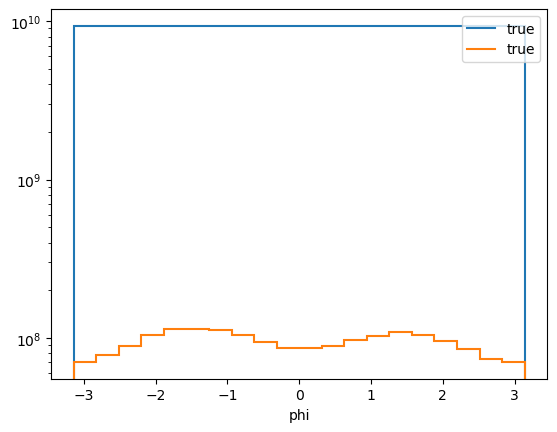

In [6]:
Hist(hist.axis.Regular(20, -np.pi, np.pi, name="phi")).fill(events.true_phi, weight=events.weight).plot(label="true")
Hist(hist.axis.Regular(20, -np.pi, np.pi, name="phi")).fill(
    events.true_phi[events.reco_mass > 0.0], weight=events.weight[events.reco_mass > 0.0]
).plot(label="true")
plt.legend()
plt.yscale("log")
plt.show()